# Exploring source measurements in a dwarf galaxy
<br>Owner(s): **Jeff Carlin** ([@jeffcarlin](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@jeffcarlin)), **Second Owner** ([@username2](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@username2))
<br>Last Verified to Run: **2020-10-02**
<br>Verified Stack Release: **20.0**

### Learning Objectives:

After working through this tutorial you should be able to: 
1. Figure out how to find and extract data around a given RA, Dec position;
2. Extract a cutout image of an object of interest, and a catalog of sources in the cutout footprint;
3. Apply quality cuts to the source catalog, and plot CMDs and spatial maps of sources;
4. Diagnose possible problems with the photometry in crowded regions;
5. Apply your understanding of the root cause of this problem to re-run photometry with different pipeline processes set up;
6. Extract well-measured photometry in the crowded region of interest, and proceed with using these data for science.

### Logistics
This notebook is intended to be runnable on `https://lsst-lsp-stable.ncsa.illinois.edu/` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.

## Set-up

The next few cells give you some options for your "Set-up" section - you may not need them all.

We'll need the `stackclub` package to be installed. If you are not developing this package, you can install it using `pip`, like this:
```
pip install git+git://github.com/LSSTScienceCollaborations/StackClub.git#egg=stackclub
```
If you are developing the `stackclub` package (eg by adding modules to it to support the Stack Club tutorial that you are writing, you'll need to make a local, editable installation. In the top level folder of the `StackClub` repo, do:

In [1]:
! cd ~/stackclub/StackClub/ && python setup.py -q develop --user && cd -

/home/jcarlin/stackclub/StackClub/Measurement


When editing the `stackclub` package files, we want the latest version to be imported when we re-run the import command. To enable this, we need the %autoreload magic command.

In [2]:
%load_ext autoreload
%autoreload 2

You can find the Stack version that this notebook is running by using eups list -s on the terminal command line:

In [3]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

nb-jcarlin-r20-0-0
lsst_distrib          20.0.0     	current v20_0_0 setup


For this tutorial we'll need the following modules:

In [4]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import IFrame, display, Markdown
from astropy.table import hstack, vstack
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy import units as u
from astropy.visualization import ZScaleInterval
from astropy.io import ascii

In [5]:
import lsst.daf.persistence as dafPersist
import lsst.daf.base as dafBase

import lsst.afw.math as afwMath
import lsst.geom as geom

import lsst.afw.detection as afwDetect
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
import lsst.afw.coord as afwCoord

import lsst.afw.display as afwDisplay

import lsst.pipe.base as pipeBase
from lsst.meas.base import NoiseReplacer, NoiseReplacerConfig

In [6]:
# Set up some plotting defaults:

params = {
   'axes.labelsize': 28,
   'font.size': 24,
   'legend.fontsize': 14,
   'xtick.major.width': 3,
   'xtick.minor.width': 2,
   'xtick.major.size': 12,
   'xtick.minor.size': 6,
   'xtick.direction': 'in',
   'xtick.top': True,
   'lines.linewidth':3,
   'axes.linewidth':3,
   'axes.labelweight':3,
   'axes.titleweight':3,
   'ytick.major.width':3,
   'ytick.minor.width':2,
   'ytick.major.size': 12,
   'ytick.minor.size': 6,
   'ytick.direction': 'in',
   'ytick.right': True,
   'figure.figsize': [9, 8]
   }

plt.rcParams.update(params)

We are going to look at a known dwarf galaxy that is present in the HSC-SSP data release, but for which (as you'll see), the photometry is poor. This galaxy is called "KKR 25" -- here is more information about KKR 25 on NED: 

https://ned.ipac.caltech.edu/byname?objname=KKR%2025&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1

To help with finding the correct tract, the tract IDs of HSC data can be found at: https://hsc-release.mtk.nao.ac.jp/doc/index.php/database/

The following data discovery section follows this demo notebook: https://github.com/lsst-sqre/notebook-demo/blob/u/jcarlin/DM-15123/hsc_cosmos_comparison.ipynb

### Find and read the data

We will point to the shared repository containing processed HSC-SSP data. 

In [7]:
depth = 'DEEP' #'WIDE' -- which survey depth (DEEP, WIDE, ULTRA-DEEP) do you want?
butler = dafPersist.Butler('/datasets/hsc/repo/rerun/DM-13666/%s/'%(depth))

With the Gen2 Butler, the easiest way to know what tracts and patches are present is to parse the filenames. This will be easier with the Gen3 Butler.

In [8]:
infiles = glob.glob('/datasets/hsc/repo/rerun/DM-13666/%s/deepCoadd-results/HSC-I/*/*/calexp-*.fits'%(depth))
# How many tract/patch files are in this repo?
print(len(infiles))

1303


In order to find which tracts/patches our target is in, we first loop over all the files in the repository and extract their central RA, Dec coordinates into a pandas dataframe.

This involves reading the "skyMap" objects from the butler repository, and using the WCS and bounding box information to extract the coordinates for each patch.

In [9]:
def getPatchCenter(skymap, tract, patch):
    # Find the center of the patch BBox in pixel coordinates and convert with tract WCS
    patch = list(map(int, patch.split(',')))
    wcs = skymap.generateTract(tract).getWcs()
    bbox = skymap.generateTract(tract).getPatchInfo(patch).getInnerBBox()
    sky = wcs.pixelToSky(np.mean((bbox.getBeginX(), bbox.getEndX())), 
                         np.mean((bbox.getBeginY(), bbox.getEndY())))
    return sky[0].asDegrees(), sky[1].asDegrees()

tract_array = []
patch_array = []

# Each line of "infiles" looks like this (infile[0]):
# '/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-I/17130/8,8/calexp-HSC-I-17130-8,8.fits'

# Split on the '/', then parse the resulting array. Here's the result of infiles[0].split('/'):
#['',
# 'datasets',
# 'hsc',
# 'repo',
# 'rerun',
# 'DM-13666',
# 'DEEP',
# 'deepCoadd-results',
# 'HSC-I',
# '17130',
# '8,8',
# 'calexp-HSC-I-17130-8,8.fits']

# So the tract number is third from the end, and patch is second from the end.

for ii in range(0, len(infiles)):
    parts = infiles[ii].split('/')
    tract_array.append(int(parts[-3]))
    patch_array.append(parts[-2])

print('Found %i patches'%(len(patch_array)))
    
skymap = butler.get('deepCoadd_skyMap')
    
ra_center_array = np.tile(0., len(patch_array))
dec_center_array = np.tile(0., len(patch_array))
for ii, (tract, patch) in enumerate(zip(tract_array, patch_array)):
    ra_center_array[ii], dec_center_array[ii] = getPatchCenter(skymap, tract, patch)
    
# Assemble in pandas data frame    
data = {'tract': tract_array,
        'patch': patch_array, 
        'ra_center': ra_center_array, 
        'dec_center': dec_center_array}
df_tract_patch = pd.DataFrame(data=data)

Found 1303 patches


Where are these data on the sky? Let's plot a map.

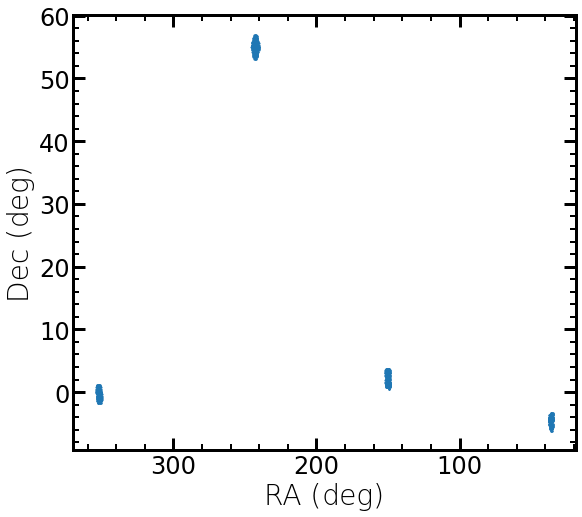

In [10]:
# Plot RA, Dec of patch centers:

fig=plt.figure()
plt.scatter(df_tract_patch['ra_center'], df_tract_patch['dec_center'], marker='.', s=5)
# From looking it up on NED, KKR 25 is in the "ELAIS-N1" field.
# Uncomment the xlim, ylim below to zoom in on that region.
#plt.xlim(238., 246.)
#plt.ylim(52., 58.)
plt.gca().invert_xaxis() # flip the x-axis so the plot is "sky-right"
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.minorticks_on()
plt.show()

### Locate KKR 25 within the patches with HSC data

To figure out which patch(es) KKR 25 is located within, we will use Astropy "SkyCoord" objects. It is then straightforward to calculate the separation of KKR 25 from the centers of all the patches we extracted above. Then we'll find the closest patches, which (hopefully) contain KKR 25.

In [11]:
# Create "SkyCoord" objects for the central coordinate of KKR25 (or CetusIII, VirgoI?), and the patch centers of HSC:
kkr25_pos = SkyCoord(243.448333*u.degree, 54.37111*u.degree, frame='icrs') # KKR25
#cosmos_patch_cen = SkyCoord(180.04*u.degree, 0.68*u.degree, frame='icrs') # VirgoI
hsc_patch_cen = SkyCoord(df_tract_patch['ra_center'].values*u.degree, df_tract_patch['dec_center'].values*u.degree, frame='icrs')

# Calculate the separation (in degrees) of each HSC patch from KKR25:
sep_patches = hsc_patch_cen.separation(kkr25_pos)

# Pick patches within 'size_select' deg of KKR25:
size_select = 0.25 # in degrees
selection_patch = (sep_patches.degree < size_select) 
print('Number of patches selected: ',np.sum(selection_patch))

# Add the separation (in arcminutes) to the dataframe:
df_tract_patch['sep_from_kkr25'] = sep_patches.arcmin

# Extract just the selected (nearby) patches:
df_selected = df_tract_patch[selection_patch]

Number of patches selected:  8


In [12]:
# Print some info about the selected patches:
df_selected

tract patch   ra_center  dec_center  sep_from_kkr25
3    17130   0,4  243.779176   54.290800       12.537841
6    17130   1,5  243.463800   54.480400        6.579589
15   17130   0,5  243.784999   54.477419       13.371343
62   17130   2,4  243.139628   54.295875       11.705172
73   17130   1,4  243.459432   54.293760        4.657199
76   17130   2,5  243.142540   54.482530       12.594279
733  17131   8,4  243.720664   54.290798       10.677045
742  17131   8,5  243.714840   54.477417       11.279527

From this table, it looks like KKR 25 is nearest the center of (tract, patch)=(17130, '1,4'). 

For context about the size of patches, HSC pixels are ~0.168" per pixel, and a patch is 4k x 4k. Thus each patch is about (4k * 0.168") = 672 arcsec = 11.2 arcmin = 0.1867 deg. on a side.

### Confirm that KKR 25 is visible in the images of these patches

To do this, we will create "data references" -- for coadd images, these are based on the filter, tract, and patch. These three dimensions specify a unique data ID, and are fed to the butler as a dictionary.

In [13]:
dataref14 = {'tract':17130, 'patch':'1,4', 'filter':'HSC-G'}

# Note that we can extract the information directly from the dataframe we made above rather
#   than explicity typing the values, like so:
#dataref14 = {'tract':df_selected.iloc[4]['tract'],'patch':df_selected.iloc[4]['patch'],
#             'filter':'HSC-G'}

If you want to know what types of data *may be* present in the butler repository, you can uncomment the following line for a list. BEWARE: it's a long list!

In [14]:
#butler.getDatasetTypes()

However, that only lists dataset types that are defined. It doesn't actually tell you if they exist *in this repository*. To find that out, you can use the "datasetExists" method. (For example, here we'll check whether the "forced_src" catalog exists for dataref14.)

In [15]:
butler.datasetExists('deepCoadd_forced_src', dataId=dataref14)

True

### Get the images and catalogs for the two patches of interest:

In particular, we'll use the forced photometry ("deepCoadd_forced_src") and the deep coadd images ("deepCoadd_calexp"). 

Notice that the *calexp* has a WCS and a "PhotoCalib" associated with it - we'll extract these for later use (if we want to convert XY pixel values to RA, Dec, or fluxes to magnitudes).

In [16]:
# Full patch image
image14 = butler.get('deepCoadd_calexp', immediate=True, dataId=dataref14)
# Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
xy0_14 = image14.getXY0() 

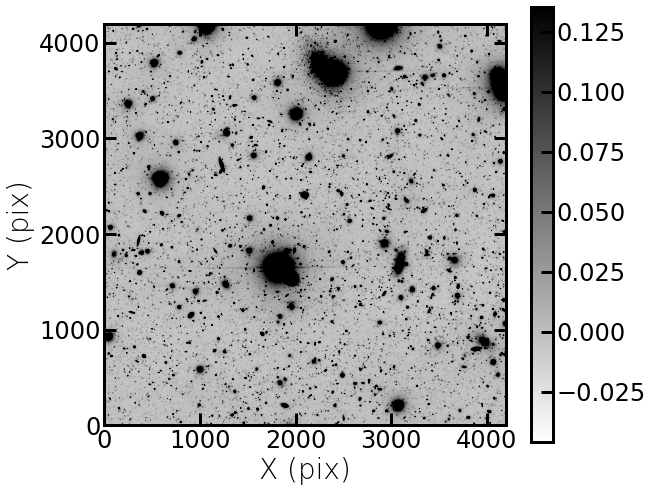

In [17]:
zscale = ZScaleInterval()

plt.rcParams.update({'figure.figsize' : (9, 8)})

vmin14, vmax14 = zscale.get_limits(image14.image.array)
# Get the dimensions of the image so we can set plot limits
imsize14 = image14.getDimensions()
plt.imshow(image14.image.array, vmin=vmin14, vmax=vmax14, cmap='binary')

# Set the plot range to the dimensions:
plt.xlim(0,imsize14[0])
plt.ylim(0,imsize14[1])
plt.colorbar()
plt.xlabel('X (pix)')
plt.ylabel('Y (pix)')

plt.show()

KKR 25 is the semi-resolved blob of stars at the top, partially obscured by a bright star.

### Create an image (from multiple patches) centered on KKR 25:
(borrowing heavily from `ip_diffim`)

Maybe instead of being limited by the patch boundaries, we would like an image that is centered on the dwarf. This will require putting together images from multiple patches

In [18]:
# A useful function we'll use in a little bit.
#   Calculate the number of pixels in a given N-arcmin area.
def arcmin2pix(narcmin):
    arcsecPerPix = 0.168  # HSC pixels are 0.168"/pixel
    arcminPerPix = arcsecPerPix / 60.0
    npix = narcmin/arcminPerPix
    return int(np.rint(npix))    

This function creates a cutout image centered on *raDec*, of size *size_arcmin*, with the center of the image in the patch denoted by *dataref*. It does the following:
1. Extract the skymap, calexp, and WCS.
2. Create an empty bounding box of the specified size, centered on the given position.
3. Taking the corners of the bounding box, use the function defined earlier to look up which patches overlap that bounding box.
4. Extract the subregions (using the "deepCoadd_calexp_sub" object) from the overlapping patches, and insert them into the bounding box we created.
5. Return the cutout image as an ExposureF.

In [19]:
def cutoutImage(raDec, size_arcmin, dataref):
    '''
    Function to extract an image cutout.
    Inputs:
      raDec: an afwGeom.SpherePoint object with desired RA, Dec center 
      size_arcmin: desired image size (in arcminutes)
      filter: desired filter of extracted image (string)
    '''
# Start with a center position and make a bbox centered there, and expand it to include data from neighboring patches:
    skyMap =  butler.get("deepCoadd_skyMap", immediate=True, dataId=dataref)
    tmp_calexp = butler.get("deepCoadd_calexp", immediate=True, dataId=dataref)
    expWcs = tmp_calexp.getWcs()

    size_pixels = arcmin2pix(size_arcmin)
    print('npixels: ',size_pixels)
    cutoutSize = geom.ExtentI(size_pixels, size_pixels) # size of cutout in pixels
    print('cutoutSize: ',cutoutSize)
    print(expWcs.skyToPixel(raDec))
    xy = geom.Point2I(expWcs.skyToPixel(raDec)) # central XY coordinate of our star's RA, Dec position

#    print('xy: ',xy,' cutoutSize: ',cutoutSize)

# Create the bounding box:
    bbox = geom.Box2I(xy - cutoutSize//2, cutoutSize)
    bbox = geom.Box2D(bbox)

    tractInfo = skyMap.findTract(raDec)
    skyCorners = [expWcs.pixelToSky(pixPos) for pixPos in bbox.getCorners()]
    patchList = tractInfo.findPatchList(skyCorners)

# compute coadd bbox
    coaddWcs = tractInfo.getWcs()
    coaddBBox = geom.Box2D()
    for skyPos in skyCorners:
        coaddBBox.include(coaddWcs.skyToPixel(skyPos))
    coaddBBox = geom.Box2I(coaddBBox)

# assemble coadd exposure from subregions of patches
    coaddExposure = afwImage.ExposureF(coaddBBox, coaddWcs)
    coaddExposure.maskedImage.set(np.nan, afwImage.Mask.getPlaneBitMask("NO_DATA"), np.nan)
    nPatchesFound = 0
    coaddFilter = None
    for patchInfo in patchList:
        patchSubBBox = patchInfo.getOuterBBox()
        patchSubBBox.clip(coaddBBox)
        patchArgDict = dict(
                            datasetType="deepCoadd_calexp_sub",
                            bbox=patchSubBBox,
                            tract=tractInfo.getId(),
                            patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
                            filter = dataref['filter'],
                            )
        print("Reading patch %s" % patchArgDict)
        coaddPatch = butler.get(**patchArgDict)
        nPatchesFound += 1
        coaddExposure.maskedImage.assign(coaddPatch.maskedImage, coaddPatch.getBBox())
        if coaddFilter is None:
            coaddFilter = coaddPatch.getFilter()

    if nPatchesFound == 0:
        raise RuntimeError("No patches found!")

    coaddExposure.setFilter(coaddFilter)
    return pipeBase.Struct(exposure=coaddExposure, sources=None)

Now define a similar function, but creating a catalog of the sources in the cutout region.

In [20]:
def cutoutCatalog(raDec, size_arcmin, dataref):
    '''
    Function to extract an catalog cutout.
    Inputs:
      raDec: an afwGeom.SpherePoint object with desired RA, Dec center 
      size_arcmin: desired image size (in arcminutes)
      filter: desired filter of extracted image (string)
    '''
# Start with a center position and make a bbox centered there, and expand it to include data from neighboring patches:
    skyMap =  butler.get("deepCoadd_skyMap", immediate=True, dataId=dataref)
    tmp_calexp = butler.get("deepCoadd_calexp", immediate=True, dataId=dataref)
    expWcs = tmp_calexp.getWcs()

    size_pixels = arcmin2pix(size_arcmin)
    cutoutSize = geom.ExtentI(size_pixels, size_pixels) # size of cutout in pixels
    xy = geom.Point2I(expWcs.skyToPixel(raDec)) # central XY coordinate of our star's RA, Dec position
    
# Create the bounding box:
    bbox = geom.Box2I(xy - cutoutSize//2, cutoutSize)
    bbox = geom.Box2D(bbox)

    tractInfo = skyMap.findTract(raDec)
    skyCorners = [expWcs.pixelToSky(pixPos) for pixPos in bbox.getCorners()]
    patchList = tractInfo.findPatchList(skyCorners)
    print('Npatches: ',len(patchList))

    nPatchesFound = 0
    for patchInfo in patchList:
        patchArgDict = dict(
                            datasetType="deepCoadd_forced_src",
                            tract=tractInfo.getId(),
                            patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
                            filter = dataref['filter'],
                            flags=afwTable.SOURCE_IO_NO_FOOTPRINTS
                            )
        print("Reading patch %s" % patchArgDict)
        src = butler.get(**patchArgDict)
        nPatchesFound += 1

        patchArgDict_ref = dict(
                                datasetType="deepCoadd_ref",
                                tract=tractInfo.getId(),
                                patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
                                filter = dataref['filter'],
                                flags=afwTable.SOURCE_IO_NO_FOOTPRINTS
                                )
        print("Reading ref cat for patch %s" % patchArgDict_ref)
        refcat = butler.get(**patchArgDict_ref)

        patchArgDict_calib = dict(
                                datasetType="deepCoadd_calexp_photoCalib",
                                tract=tractInfo.getId(),
                                patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
                                filter = dataref['filter'],
                                flags=afwTable.SOURCE_IO_NO_FOOTPRINTS
                                )
        print("Reading calib for patch %s" % patchArgDict_calib)
        calib = butler.get(**patchArgDict_calib)
        psfmags = calib.instFluxToMagnitude(src, 'base_PsfFlux')
        modelmags = calib.instFluxToMagnitude(src, 'modelfit_CModel')
        
        # Create an empty Astropy Table, then insert the magnitudes into it.
        mags = Table()
        mags['psfmag'] = psfmags
        mags['modelmag'] = modelmags


        if nPatchesFound == 1:
            print('patch: 1')
            tmp_src = src
            tmp_ref = refcat
            tmp_mags = mags
            tmp_calib = calib
        else:
            print('patch: ',nPatchesFound)
            tmp_src.extend(src)
            tmp_ref.extend(refcat)
            tmp_mags = vstack([tmp_mags,mags])
            
        print('length of tmp_src, tmp_ref, tmp_mags: ',len(tmp_src),len(tmp_ref), len(tmp_mags))


    print('Making deep copies')
    cat_final = tmp_src.copy(deep = True)
    ref_final = tmp_ref.copy(deep = True)


    if nPatchesFound == 0:
        raise RuntimeError("No patches found!")

    return cat_final, ref_final, tmp_mags

In [21]:
size_arcmin = 3.0

# Create a SpherePoint object at the center of KKR 25:
raDec = geom.SpherePoint(kkr25_pos.ra.value, kkr25_pos.dec.value, geom.degrees)

# Extract the cutout image:
imgCutout = cutoutImage(raDec, size_arcmin, dataref14)

npixels:  1071
cutoutSize:  (1071, 1071)
(6161.1, 19656)
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5626, 19120), dimensions=Extent2I(1072, 980)), 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G'}
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5626, 19900), dimensions=Extent2I(1072, 292)), 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G'}


Notice from the outputs of the previous cell that two patches were needed to create the image. Now, how does it look? (Can we clearly see the dwarf galaxy in it?)

<Figure size 648x576 with 0 Axes>

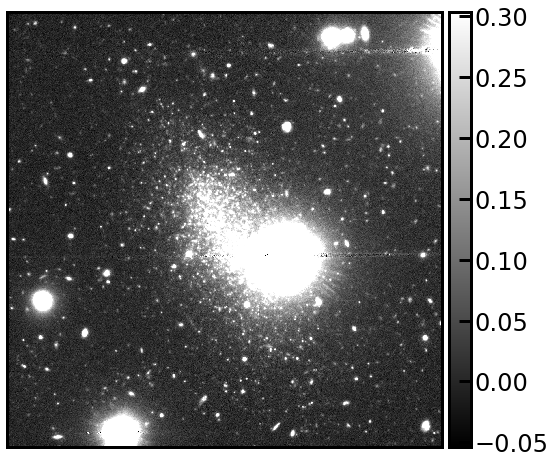

In [22]:
plt.rcParams.update({'figure.figsize' : (9, 8)})

# Use lsst.afw.display with the matplotlib backend to display the image
afwDisplay.setDefaultBackend('matplotlib') 
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('linear', 'zscale')
afw_display.mtv(imgCutout.exposure.image)
plt.xticks([])
plt.yticks([])
# plt.savefig('kkr25_image.png') # Uncomment if you want to save the image.
plt.show()

There's a beautiful, partially-resolved galaxy there. Unfortunately, there's a bright star right next to it. We'll have to see how that affects the measurements from the Stack.

What does the mask plane look like in this region?

<Figure size 648x576 with 0 Axes>

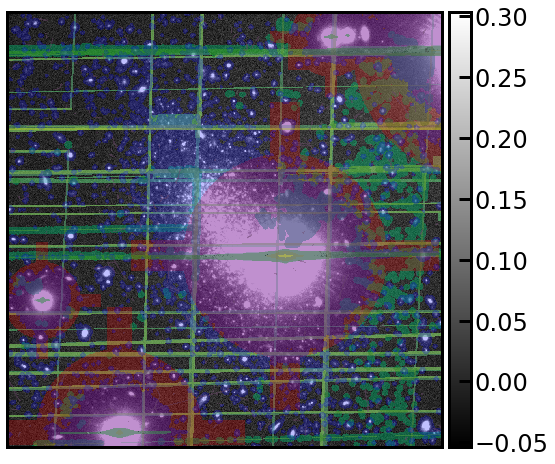

In [23]:
afwDisplay.setDefaultBackend('matplotlib') 
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('linear', 'zscale')
afw_display.mtv(imgCutout.exposure.maskedImage)
plt.xticks([])
plt.yticks([])
plt.show()

In [24]:
# The MaskedImage is overplotting the values of the mask plane. 
# Extract the mapping between mask color and mask bit directly from the mask object:

for maskName, maskBit in imgCutout.exposure.mask.getMaskPlaneDict().items():
    print('{}: {}'.format(afw_display.getMaskPlaneColor(maskName),maskName))

red: BAD
None: BRIGHT_OBJECT
None: CLIPPED
magenta: CR
None: CROSSTALK
blue: DETECTED
cyan: DETECTED_NEGATIVE
yellow: EDGE
None: INEXACT_PSF
green: INTRP
None: NOT_DEBLENDED
orange: NO_DATA
None: REJECTED
green: SAT
None: SENSOR_EDGE
yellow: SUSPECT
None: UNMASKEDNAN


OK, so this is telling us that the stars in KKR 25 (because they are blue in the mask) are flagged as DETECTED, but are mostly beneath the BAD mask from the bright star. 

Extract concatenated source catalogs in the same footprint using the function we defined above. (Note: this returns catalog data for the entire patches that are part of the requested footprint, and not just within the radius specified.) We'll grab three bands (gri).

The *cutoutCatalog* function returns the forced photometry ("deepCoadd_forced_src"), the reference catalog of combined information for all bandpasses ("deepCoadd_ref"), and the calibrated magnitudes (PSF and cmodel magnitudes).

*The following cell may take a few minutes to execute.*

In [25]:
dr14_i = dataref14.copy()
dr14_i['filter'] = 'HSC-I'
dr14_r = dataref14.copy()
dr14_r['filter'] = 'HSC-R'
dr14_g = dataref14.copy()
dr14_g['filter'] = 'HSC-G'
cat_g, refcat_g, mags_g = cutoutCatalog(raDec, size_arcmin, dr14_g)
cat_r, refcat_r, mags_r = cutoutCatalog(raDec, size_arcmin, dr14_r)
cat_i, refcat_i, mags_i = cutoutCatalog(raDec, size_arcmin, dr14_i)

Npatches:  2
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
Reading ref cat for patch {'datasetType': 'deepCoadd_ref', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
Reading calib for patch {'datasetType': 'deepCoadd_calexp_photoCalib', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
patch: 1
length of tmp_src, tmp_ref, tmp_mags:  30285 30285 30285
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
Reading ref cat for patch {'datasetType': 'deepCoadd_ref', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
Reading calib for patch {'datasetType': 'deepCoadd_calexp_photoCalib', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
patch:  2
length of tmp_src, tmp_ref, tmp_mags:  61007 61007 61007
Making deep copies
Npatches:  2
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch

### Make some selections based on the data flags:

 - detect_isPrimary (see https://pipelines.lsst.io/getting-started/multiband-analysis.html?#filtering-for-unique-deblended-sources-with-the-detect-isprimary-flag for a description of what that flag means), 
 - require PSF fluxes to be measured (i.e., not 'NaN'), 
 - point sources (based on ClassificationExtendedness)

In [26]:
is_primary = (refcat_g['detect_isPrimary'] == True) & (refcat_r['detect_isPrimary'] == True) &\
             (refcat_i['detect_isPrimary'] == True) 
is_finite = (np.isfinite(cat_g.getPsfInstFlux())) & (np.isfinite(cat_r.getPsfInstFlux())) & (np.isfinite(cat_i.getPsfInstFlux()))
ptsource = (cat_g['base_ClassificationExtendedness_flag'] == False) & (cat_r['base_ClassificationExtendedness_flag'] == False) & (cat_i['base_ClassificationExtendedness_flag'] == False)

### Scatter plots of the source positions with various subsets selected:

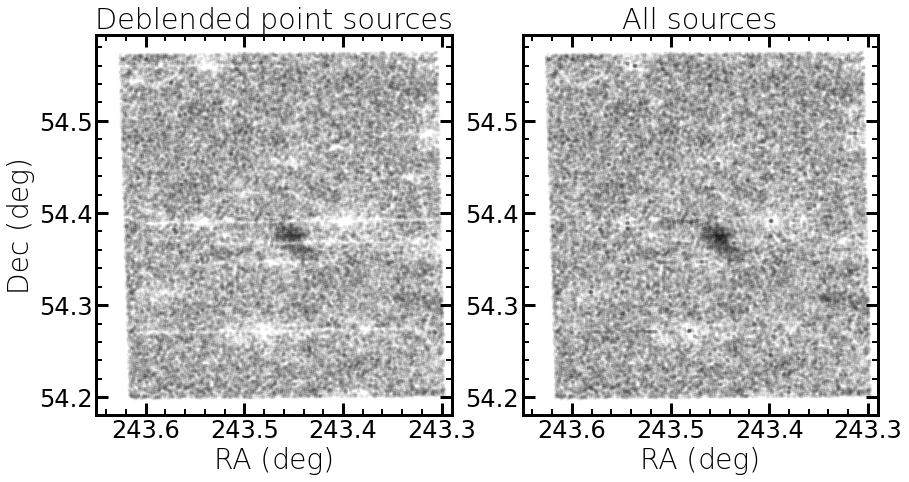

In [27]:
plt.rcParams.update({'figure.figsize' : (14, 7)})

plt.subplot(121)
plt.plot(np.rad2deg(cat_g['coord_ra'][is_primary & ptsource]),np.rad2deg(cat_g['coord_dec'][is_primary & ptsource]),'k.',alpha=0.05)
plt.xlim(243.65,243.29)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.minorticks_on()
plt.title('Deblended point sources')

plt.subplot(122)
plt.plot(np.rad2deg(cat_g['coord_ra'][is_primary]),np.rad2deg(cat_g['coord_dec'][is_primary]),'k.',alpha=0.05)
plt.xlim(243.65,243.29)
plt.title('All sources')
plt.xlabel('RA (deg)')
plt.minorticks_on()

Good - we can see a concentration of sources in the center, which correspond to KKR 25.

## Plot a color-magnitude diagram (CMD) of objects near KKR 25:

Because the stack uses PanSTARRS-1 (PS1) for photometric calibration, we will overplot a PS1 isochrone for comparison. This was downloaded from the Padova isochrones web interface (http://stev.oapd.inaf.it/cgi-bin/cmd_3.3).

In [28]:
# Read in the isochrone file:
iso = ascii.read('/project/jcarlin/isochrones/parsec12_panstarrs1/0_000500.dat',header_start = 13)

dist = 1.7e6 # in pc # Roughly the distance to KKR 25 (see the NED link above)
ebv = 0.008 # (E(B-V) = 0.008 according to Makarov+2012) -- You could also look this up using the central coordinates.
dmod = 5.0*np.log10(dist) - 5.0 # convert distance to distance modulus

# Raw PS1-band isochrone magnitudes
g_iso_ps1 = iso['gP1']
r_iso_ps1 = iso['rP1']
i_iso_ps1 = iso['iP1']

# Extinction coefficients from Schlafly+2011:
A_g = 3.172 * ebv
A_r = 2.271 * ebv
A_i = 1.682 * ebv

# NOTE: we are *adding* extinction to the isochrone, instead of looking up the values for all stars. We'll work with
#   un-dereddened magnitudes throughout.
g_iso = g_iso_ps1 + dmod + A_g
r_iso = r_iso_ps1 + dmod + A_r
i_iso = i_iso_ps1 + dmod + A_i 

In [29]:
# Select a smaller region around KKR 25:
coord_g = SkyCoord(cat_g['coord_ra']*u.radian, cat_g['coord_dec']*u.radian, frame='icrs')
### Notice in the line above that coordinates in the catalog are in radians by default.

# Calculate the separation (in degrees) of each HSC patch from KKR25:
sep_kkr25 = coord_g.separation(kkr25_pos)

# Select within some small radius:
sel_rad = 2.5 # radius in arcminutes
sel_cen = (sep_kkr25.arcmin < sel_rad)

The following uses the difference in PSF and cmodel magnitudes to select things that are "star-like". See the Bosch+2018 paper on the HSC pipeline (https://ui.adsabs.harvard.edu/abs/2018PASJ...70S...5B/abstract) for info about this. The "classification_extendedness" flag should have taken care of this already, but this is a way of refining that if you want a stricter selection.

In [30]:
# difference in mags (PSF - cmodel)
magdiff_i = mags_i['psfmag'][:,0]-mags_i['modelmag'][:,0]
starsel_i = (np.abs(magdiff_i) < 0.05)

/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


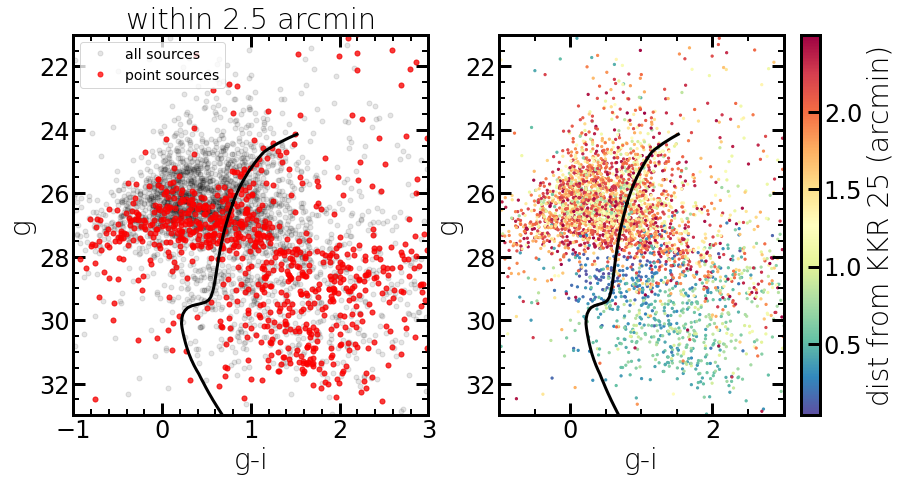

In [31]:
plt.rcParams.update({'figure.figsize' : (14, 7)})

plt.figure()

# The following selects only up to the RGB tip (i.e., no post-RGB, AGB, etc.) from the isochrone, for clarity
okstage = (iso['stage'] <= 3)

plt.subplot(121)
plt.plot(mags_g['psfmag'][is_primary & sel_cen][:,0]-mags_i['psfmag'][is_primary & sel_cen][:,0],\
         mags_g['psfmag'][is_primary & sel_cen][:,0], 'ko', ms=5, alpha=0.1, label='all sources')
plt.plot(mags_g['psfmag'][is_primary & starsel_i & sel_cen][:,0]-mags_i['psfmag'][is_primary & starsel_i & sel_cen][:,0],\
         mags_g['psfmag'][is_primary & starsel_i & sel_cen][:,0], 'ro', ms=5, alpha=0.75, label='point sources')
plt.plot(g_iso[okstage]-i_iso[okstage], g_iso[okstage], 'k', label='__no label__')#s', ms=1)
plt.xlabel('g-i')
plt.ylabel('g')
plt.legend()
plt.xlim(-1,3)
plt.ylim(33,21)
plt.title('within 2.5 arcmin')
plt.minorticks_on()

plt.subplot(122)
plt.scatter(mags_g['psfmag'][is_primary & sel_cen][:,0]-mags_i['psfmag'][is_primary & sel_cen][:,0],\
            mags_g['psfmag'][is_primary & sel_cen][:,0], c=sep_kkr25[is_primary & sel_cen].arcmin, cmap='Spectral_r', s=5)
plt.plot(g_iso[okstage]-i_iso[okstage], g_iso[okstage], 'k')#s', ms=1)
plt.xlabel('g-i')
plt.ylabel('g')
plt.xlim(-1,3)
plt.ylim(33,21)
plt.colorbar(label='dist from KKR 25 (arcmin)')
plt.minorticks_on()
plt.show()
#plt.savefig('cmds_kkr25_noisereplace_on.png')

So, we can see that most of the stars nearest the center of KKR 25 (the blue/green points above) have "bogus" photometry (i.e., g > 28th mag).

Just to confirm that it is the stars near KKR 25 that are getting set to unrealistically faint magnitudes, let's plot the positions of objects classified as point sources, color-coded by their g-band PSF magnitude.

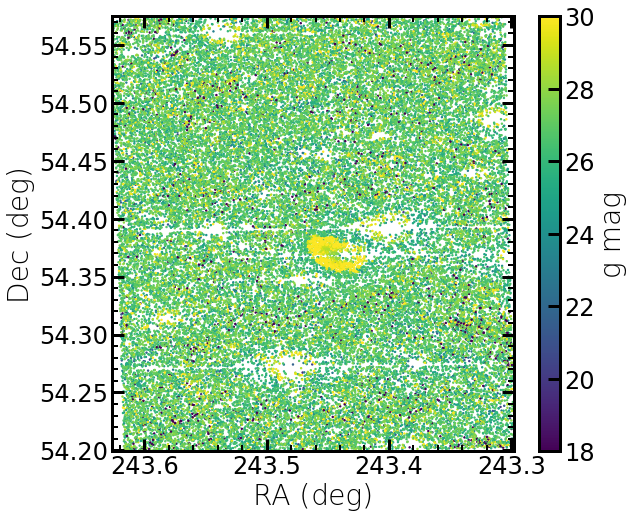

In [32]:
plt.rcParams.update({'figure.figsize' : (9, 8)})

gmags0 = mags_g['psfmag']
gmags0[np.isnan(gmags0)] = 0.0
plt.scatter(np.rad2deg(cat_g['coord_ra'][is_primary & ptsource]),\
            np.rad2deg(cat_g['coord_dec'][is_primary & ptsource]),\
            c=gmags0[is_primary & ptsource][:,0],s=2,vmax=30,vmin=18)
# NOTE: in the above line, gmags0 must be subscripted to select only the magnitude column. gmags0 contains both the
#       magnitudes and their errors, so to get mags only, use gmags0[:0] (for errors, use gmags0[:1])

plt.xlim(np.max(np.rad2deg(cat_g['coord_ra'][is_primary & ptsource])),\
         np.min(np.rad2deg(cat_g['coord_ra'][is_primary & ptsource])))
plt.ylim(np.min(np.rad2deg(cat_g['coord_dec'][is_primary & ptsource])),\
         np.max(np.rad2deg(cat_g['coord_dec'][is_primary & ptsource])))
plt.colorbar(label='g mag')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.minorticks_on()

Most of the sources in KKR25, while detected, seem to have magnitudes >= 30(!). This is unrealistically faint - for example, in the CMDs above, you can see that the faintest reliably-measured objects are at g~27.

Plot magnitude vs. position to see if it is true that the g>28 sources are concentrated in KKR25.

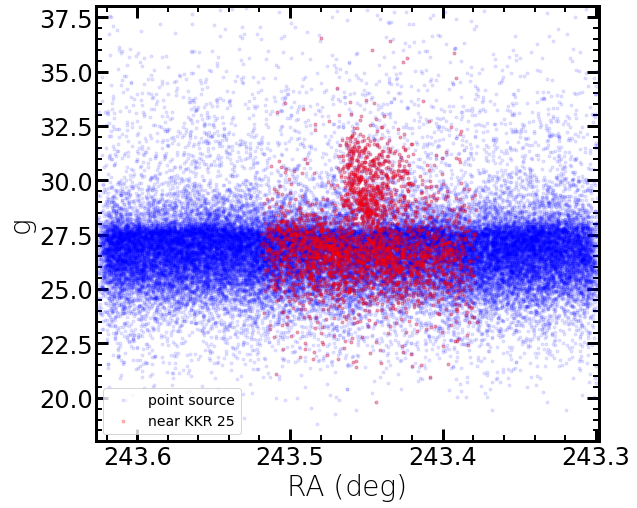

In [33]:
plt.plot(np.rad2deg(cat_g['coord_ra'][is_primary & ptsource]),\
         gmags0[is_primary & ptsource][:,0],'b.',alpha=0.1, label='point source')
plt.plot(np.rad2deg(cat_g['coord_ra'][is_primary & ptsource & sel_cen]),\
         gmags0[is_primary & ptsource & sel_cen][:,0],'r.',alpha=0.25, label='near KKR 25')
plt.ylim(18,38)
plt.xlim(np.max(np.rad2deg(cat_g['coord_ra'][is_primary & ptsource])),\
         np.min(np.rad2deg(cat_g['coord_ra'][is_primary & ptsource])))
plt.legend()
plt.xlabel('RA (deg)')
plt.ylabel('g')
plt.minorticks_on()

Sure enough, there is a big blob of objects at RA~243.45, with magnitudes fainter than g>28. So, it looks like the Stack *detects* sources in the center, but when it measures them, something goes wrong.

After some exploration, we have figured out what happens in cases like this. After detecting sources in an image, the measurements are done by *first replacing the flux in all neighboring footprints with noise*, then measuring the flux of the source of interest. In crowded regions such as KKR 25, the footprints of neighboring sources almost always overlap the source of interest, meaning the source itself gets replaced with noise before running the measurement task. This means that the measurement returns only background noise, or a flux consistent with zero.

## Try using the noise replacer to replace the detection footprints with noise

Just to confirm that this is the issue, let's try using the "Noise Replacer" to replace footprints with noise in the image, to see how the footprints in some small region look.

For more details on footprints and the noise replacer, see the Stack Club "Footprints" notebook in the Source Detection section: https://stackclub.readthedocs.io/en/latest/notebooks.html#source-detection

In [34]:
## Source catalog:
cat14 = butler.get('deepCoadd_forced_src', dataId=dr14_g)

# Reference object:
ref14 = butler.get('deepCoadd_ref', dataId=dr14_g)

# Calibrated exposure:
calexp14 = butler.get('deepCoadd_calexp', dataId=dr14_g)
# We are going to manipulate calexp14, so make a clone of the original:
calexp14_orig = calexp14.clone()

In [35]:
# extract the footprints of all detected sources into a dict:
fp_dict_g = {measRecord.getId(): (measRecord.getParent(), measRecord.getFootprint()) for measRecord in ref14}

In [36]:
# Instantiate the NoiseReplacer and feed it the calexp image and the footprints:
nr_config = NoiseReplacerConfig()
noiseReplacer = NoiseReplacer(nr_config, calexp14, fp_dict_g)

<Figure size 648x576 with 0 Axes>

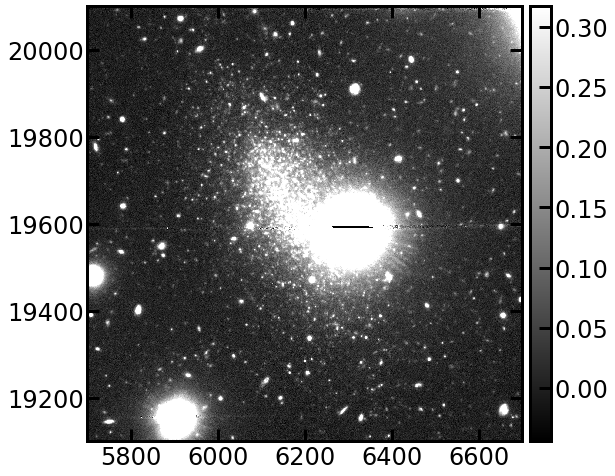

In [37]:
# Display the original image:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('linear', 'zscale')
afw_display.mtv(calexp14_orig.getImage()[5700:6700,19100:20100])

<Figure size 648x576 with 0 Axes>

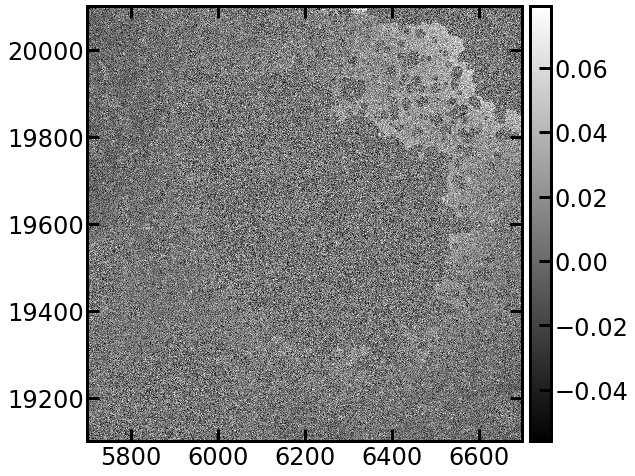

In [38]:
# Display the image with the source footprints replaced by noise:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('linear', 'zscale')
afw_display.mtv(calexp14.getImage()[5700:6700,19100:20100])

The fact that they subtracted off nicely confirms that the sources in KKR 25 were *detected*. Now the question is whether one can get *measurements* for those detected objects.

In [39]:
# Extract a small cutout image, offset slightly from the center of KKR 25, for efficiency:
cutout_pos = SkyCoord(kkr25_pos.ra+(0.5*u.arcmin), kkr25_pos.dec+(0.5*u.arcmin), frame='icrs') # KKR25
raDec_cutout = geom.SpherePoint(cutout_pos.ra.value, cutout_pos.dec.value, geom.degrees)
# Extract the cutout image:
cutout_size = 0.4 # in arcmin
gcutout = cutoutImage(raDec_cutout, cutout_size, dr14_g)
icutout = cutoutImage(raDec_cutout, cutout_size, dr14_i)
gcat, grefcat, gcutout_mags = cutoutCatalog(raDec_cutout, cutout_size, dr14_g)
icat, irefcat, icutout_mags = cutoutCatalog(raDec_cutout, cutout_size, dr14_i)

npixels:  143
cutoutSize:  (143, 143)
(6059.5, 19836)
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5987, 19764), dimensions=Extent2I(145, 144)), 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G'}
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5987, 19900), dimensions=Extent2I(145, 8)), 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G'}
npixels:  143
cutoutSize:  (143, 143)
(6059.5, 19836)
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5987, 19764), dimensions=Extent2I(145, 144)), 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-I'}
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5987, 19900), dimensions=Extent2I(145, 8)), 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-I'}
Npatches:  2
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
Reading ref cat for patch {'datasetType': 

In [40]:
# data quality cuts as we did before
is_primary_cutout = (grefcat['detect_isPrimary'] == True) &\
                    (irefcat['detect_isPrimary'] == True) 
is_finite_cutout = (np.isfinite(gcat.getPsfInstFlux())) & (np.isfinite(icat.getPsfInstFlux()))
magcut_cutout = (gcutout_mags['psfmag'][:,0] < 28.0)
ptsource_cutout = (gcat['base_ClassificationExtendedness_flag'] == False) &\
                  (icat['base_ClassificationExtendedness_flag'] == False)

In [42]:
# Cut down the list of footprints from the entire calexp to only those in the small subregion of interest:
# X: 5970-6130, Y: 19775-19905
xmin = 5970
xmax = 6130
ymin = 19775
ymax = 19905
keep14 = (ref14.getX() < xmax) & (ref14.getX() > xmin) & (ref14.getY() < ymax) & (ref14.getY() > ymin)
ref14keep = ref14[keep14]
fp_dict_g14 = {measRecord.getId(): (measRecord.getParent(), measRecord.getFootprint()) for measRecord in ref14keep}
srcids14 = ref14keep['id']

Now we have a list (srcids14) of the ids for all the source footprints in the region of interest.

In [43]:
# Make another clone of the calexp image, in which we will:
# (a) Replace pixels in all source footprints with noise, then
# (b) Add a single source footprint's back into the image.

c14 = calexp14_orig.clone()

# Instantiate the NoiseReplacer and feed it the calexp image and the footprints:
nr_config = NoiseReplacerConfig()
noiseReplacer = NoiseReplacer(nr_config, c14, fp_dict_g14)

# The following line simply selects an index number for which source (from srcids14) to visualize.
# (Change the integer to visualize a different source.)
ind = 17 # 53, 55, 56 are huge!, 21 is crazy huge!
noiseReplacer.insertSource(srcids14[ind])
print('(X,Y): ', ref14keep[ind].getX(), ref14keep[ind].getY())

(X,Y):  5990.871406813854 19843.57847613764


In [44]:
# Extract the image array for the selected footprint:
fp = fp_dict_g14[srcids14[ind]][1].getSpans().unflatten(fp_dict_g14[srcids14[ind]][1].getImageArray())
# Extract the bounding box for the footprint:
fp_bbox = fp_dict_g14[srcids14[ind]][1].getBBox()

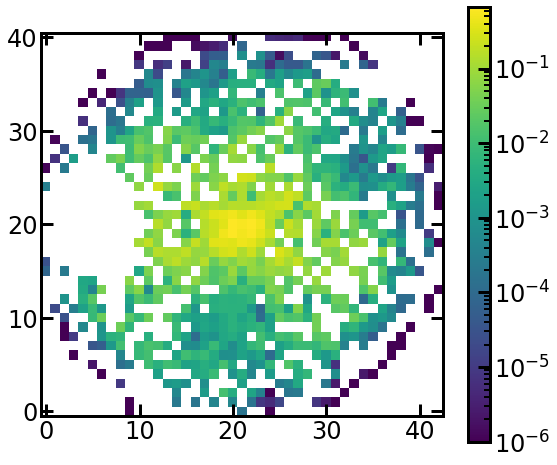

In [45]:
from matplotlib.colors import LogNorm
plt.imshow(fp,
           cmap='viridis', origin='lower', norm=LogNorm(vmin=1e-6, vmax=fp.max()))
plt.colorbar()

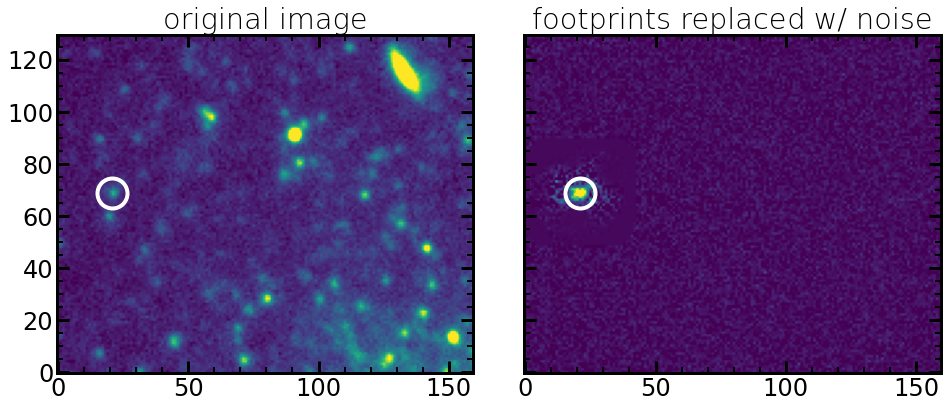

In [46]:
plt.rcParams.update({'figure.figsize' : (14, 7)})

f, ax = plt.subplots(nrows=1, ncols=2, sharey=True)

axflat = ax.flatten()
ax1 = axflat[0]
ax2 = axflat[1]
data = calexp14_orig.getMaskedImage()[xmin:xmax,ymin:ymax].getImage().array
ax1.minorticks_on()
ax1.imshow(data, origin='lower',vmin=-0.01, vmax=0.5)
ax1.plot(ref14keep[ind].getX()-xmin, ref14keep[ind].getY()-ymin, 'o', ms=30, color='white', fillstyle='none', markeredgewidth=4)
ax1.set_title('original image')

data = c14.getMaskedImage()[xmin:xmax,ymin:ymax].getImage().array
ax2.imshow(data, origin='lower',vmin=-0.01, vmax=0.5)
ax2.plot(ref14keep[ind].getX()-xmin, ref14keep[ind].getY()-ymin, 'o', ms=30, color='white', fillstyle='none', markeredgewidth=4)
ax2.minorticks_on()
ax2.set_title('footprints replaced w/ noise')
plt.tight_layout()

This one looks like a reasonable point source. However, if you try different footprints, you will see that some of them span *large* areas, such that if you subtract them off before doing measurements, you will have nothing left to measure. Let's look at one of those large footprints:

In [47]:
# Make another clone of the calexp image, in which we will:
# (a) Replace pixels in all source footprints with noise, then
# (b) Add a single source footprint's back into the image.

c14 = calexp14_orig.clone()

# Instantiate the NoiseReplacer and feed it the calexp image and the footprints:
noiseReplacer = NoiseReplacer(nr_config, c14, fp_dict_g14)

# The following line simply selects an index number for which source (from srcids14) to visualize.
# (Change the integer to visualize a different source.)
ind_large = 56
noiseReplacer.insertSource(srcids14[ind_large])
print('(X,Y): ', ref14keep[ind_large].getX(), ref14keep[ind_large].getY())

(X,Y):  6079.256735240704 19830.9733978407


In [48]:
# Extract the image array for the selected footprint:
fp_large = fp_dict_g14[srcids14[ind_large]][1].getSpans().unflatten(fp_dict_g14[srcids14[ind_large]][1].getImageArray())
# Extract the bounding box for the footprint:
fp_bbox_large = fp_dict_g14[srcids14[ind_large]][1].getBBox()

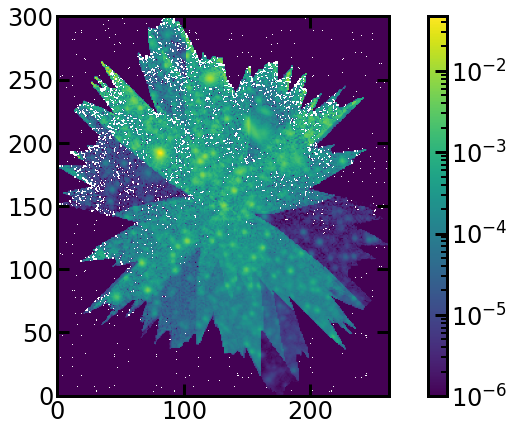

In [49]:
plt.imshow(fp_large,
           cmap='viridis', origin='lower', norm=LogNorm(vmin=1e-6, vmax=fp_large.max()))
plt.colorbar()
plt.show()

Whoa, this thing is huge. It has connected the pixels of many detected sources into one contiguous footprint. (Notice that this footprint's area is larger than the 160x130-pixel cutout image that we selected.)

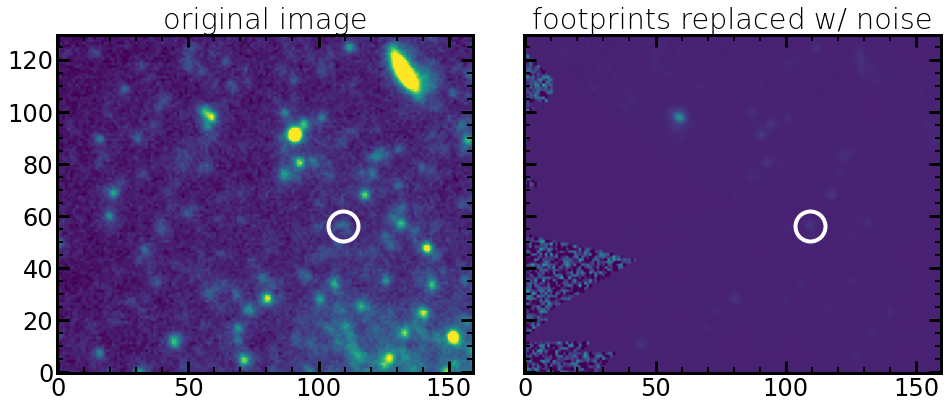

In [50]:
plt.rcParams.update({'figure.figsize' : (14, 7)})

f, ax = plt.subplots(nrows=1, ncols=2, sharey=True)

axflat = ax.flatten()
ax1 = axflat[0]
ax2 = axflat[1]
data = calexp14_orig.getMaskedImage()[xmin:xmax,ymin:ymax].getImage().array
ax1.minorticks_on()
ax1.imshow(data, origin='lower',vmin=-0.01, vmax=0.5)
ax1.plot(ref14keep[ind_large].getX()-xmin, ref14keep[ind_large].getY()-ymin, 'o', ms=30, color='white', fillstyle='none', markeredgewidth=4)
ax1.set_title('original image')

data = c14.getMaskedImage()[xmin:xmax,ymin:ymax].getImage().array
ax2.imshow(data, origin='lower',vmin=-0.01, vmax=0.1)
ax2.plot(ref14keep[ind_large].getX()-xmin, ref14keep[ind_large].getY()-ymin, 'o', ms=30, color='white', fillstyle='none', markeredgewidth=4)
ax2.minorticks_on()
ax2.set_title('footprints replaced w/ noise')
plt.tight_layout()

You can see in the right panel that the selected footprint fills almost the entire sub-image. Also note that there are resolved sources visible *within* that footprint, so that masking this footprint would make those sources unmeasureable. Clearly, these oversized footprints are the reason we get ~zero fluxes for stars in the crowded parts of KKR 25.

One last thing to check: we can extract the area of each footprint, so that we could imagine testing whether this issue had happened in a given region by examining footprint sizes.

In [51]:
# Check the area of the footprints we have selected:
srctmp = ref14keep[ind]
fprtmp = srctmp.getFootprint()
srctmp_large = ref14keep[ind_large]
fprtmp_large = srctmp_large.getFootprint()
print(fprtmp.getArea(),' pixels^2, ',fprtmp_large.getArea(),' pixels^2')

1582  pixels^2,  46125  pixels^2


### Re-run forced photometry, but without replacing all the footprints with noise:

For this section, we will re-run the photometry, turning off the feature that replaces neighboring footprints with noise. Rather than doing this in the notebook, I instead re-ran the relevant tasks from the command line. The following gives a brief summary of how this was done:

Some recent processing of HSC-PDR2 resides at: /datasets/hsc/repo/rerun/DM-23243

```
source /opt/lsst/software/stack/loadLSST.bash
setup -t v20_0_0 lsst_distrib
setup obs_subaru

multiBandDriver.py /datasets/hsc/repo --rerun DM-23243/DEEP:/project/jcarlin/kkr25/rerun/noise_replace_offPDR2 --id tract=17130 filter=HSC-G^HSC-I^HSC-R --batch-type=slurm --mpiexec='-bind-to socket' --job mbKKR25 --time 30000 --nodes 2 --procs 23 —configfile 'mbconfig.py' 
```

The file 'mbconfig.py' contains the following:
```
config.measureCoaddSources.measurement.doReplaceWithNoise=False
config.forcedPhotCoadd.measurement.doReplaceWithNoise=False
```

Once that has finished running, we can examine the outputs.

In [52]:
butler = dafPersist.Butler('/project/jcarlin/kkr25/rerun/noise_replace_offPDR2')

Extract catalogs from this new repository in a small region centered on KKR 25:

In [53]:
size_arcmin = 3.0

# Create a SpherePoint object at the center of KKR 25:
raDec = geom.SpherePoint(kkr25_pos.ra.value, kkr25_pos.dec.value, geom.degrees)

# Tract/patch where KKR 25's center appears
tract = 17130
patch = '1,4'
dr14_g = {'tract':tract, 'patch':patch, 'filter':'HSC-G'}
dr14_r = {'tract':tract, 'patch':patch, 'filter':'HSC-R'}
dr14_i = {'tract':tract, 'patch':patch, 'filter':'HSC-I'}

cat_g, refcat_g, mags_g = cutoutCatalog(raDec, size_arcmin, dr14_g)
cat_r, refcat_r, mags_r = cutoutCatalog(raDec, size_arcmin, dr14_r)
cat_i, refcat_i, mags_i = cutoutCatalog(raDec, size_arcmin, dr14_i)

Npatches:  2
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
Reading ref cat for patch {'datasetType': 'deepCoadd_ref', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
Reading calib for patch {'datasetType': 'deepCoadd_calexp_photoCalib', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
patch: 1
length of tmp_src, tmp_ref, tmp_mags:  25597 25597 25597
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
Reading ref cat for patch {'datasetType': 'deepCoadd_ref', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
Reading calib for patch {'datasetType': 'deepCoadd_calexp_photoCalib', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
patch:  2
length of tmp_src, tmp_ref, tmp_mags:  53655 53655 53655
Making deep copies
Npatches:  2
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch

Apply quality cuts to select "good," point-source-like objects.

In [54]:
is_primary = (refcat_g['detect_isPrimary'] == True) & (refcat_r['detect_isPrimary'] == True) &\
             (refcat_i['detect_isPrimary'] == True) 
is_finite = (np.isfinite(cat_g.getPsfInstFlux())) & (np.isfinite(cat_r.getPsfInstFlux())) & (np.isfinite(cat_i.getPsfInstFlux()))
deblended = (cat_g['deblend_nChild'] == 0) & (cat_r['deblend_nChild'] == 0) & (cat_i['deblend_nChild'] == 0)
ptsource = (cat_g['base_ClassificationExtendedness_flag'] == False) & (cat_r['base_ClassificationExtendedness_flag'] == False) & (cat_i['base_ClassificationExtendedness_flag'] == False)

The following cell is not totally necessary, but is a convenient way to change the radius of the selection cone.

In [55]:
# Select a smaller region around KKR 25:
coord_g = SkyCoord(cat_g['coord_ra']*u.radian, cat_g['coord_dec']*u.radian, frame='icrs')

# Calculate the separation (in degrees) of each HSC patch from KKR25:
sep_kkr25 = coord_g.separation(kkr25_pos)

# Select within some small radius:
sel_rad = 2.5
sel_cen = (sep_kkr25.arcmin < sel_rad)

As before, we will select a more reliable set of "stars" using cuts on the difference between model and PSF magnitudes.

In [56]:
# difference in mags (PSF - cmodel)
magdiff_i = mags_i['psfmag'][:,0]-mags_i['modelmag'][:,0]
starsel_i = (np.abs(magdiff_i) < 0.05)

/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


#### Drumroll please...

Now we are ready to check the CMD of sources measured with noise replacement turned off. Hopefully we will see a well-defined red giant branch of KKR 25...

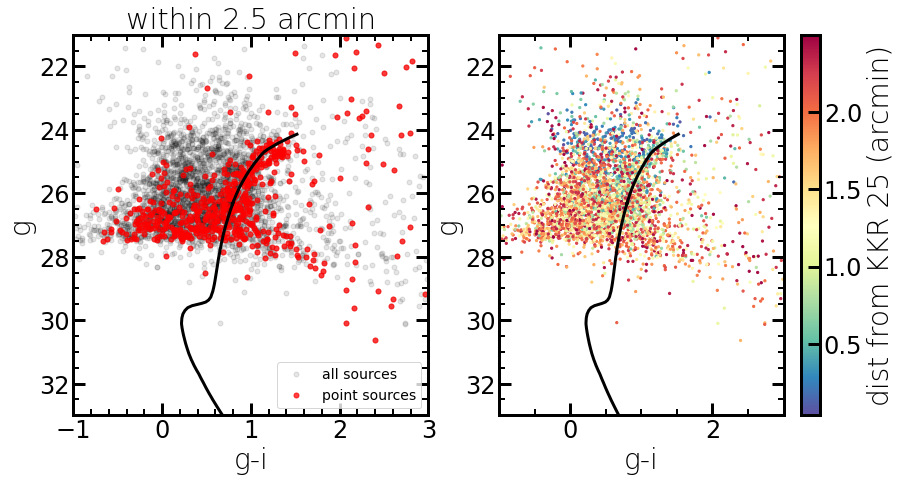

In [57]:
plt.rcParams.update({'figure.figsize' : (14, 7)})

plt.figure()

okstage = (iso['stage'] <= 3)

plt.subplot(121)
plt.plot(mags_g['psfmag'][is_primary & deblended & sel_cen][:,0]-mags_i['psfmag'][is_primary & deblended & sel_cen][:,0],\
         mags_g['psfmag'][is_primary & deblended & sel_cen][:,0], 'ko', ms=5, alpha=0.1, label='all sources')
plt.plot(mags_g['psfmag'][is_primary & deblended & starsel_i & sel_cen][:,0]-mags_i['psfmag'][is_primary & deblended & starsel_i & sel_cen][:,0],\
         mags_g['psfmag'][is_primary & deblended & starsel_i & sel_cen][:,0], 'ro', ms=5, alpha=0.75, label='point sources')
plt.plot(g_iso[okstage]-i_iso[okstage], g_iso[okstage], 'k', label='__no label__')#s', ms=1)
plt.xlabel('g-i')
plt.ylabel('g')
plt.legend()
plt.xlim(-1,3)
plt.ylim(33,21)
plt.title('within 2.5 arcmin')
plt.minorticks_on()

plt.subplot(122)
plt.scatter(mags_g['psfmag'][is_primary & sel_cen][:,0]-mags_i['psfmag'][is_primary & sel_cen][:,0],\
            mags_g['psfmag'][is_primary & sel_cen][:,0], c=sep_kkr25[is_primary & sel_cen].arcmin, cmap='Spectral_r', s=5)
plt.plot(g_iso[okstage]-i_iso[okstage], g_iso[okstage], 'k')#s', ms=1)
plt.xlabel('g-i')
plt.ylabel('g')
plt.xlim(-1,3)
plt.ylim(33,21)
plt.colorbar(label='dist from KKR 25 (arcmin)')
plt.minorticks_on()
plt.show()

Success! The red points in the left panel clearly define a red giant branch consistent with the known distance to KKR 25 (as evidenced by the fact that the isochrone matches the data pretty well).

Notice also that, unlike before, there are very few points fainter than g=28. This is a good thing, since those were all junk. Let's zoom in on the CMD and bask in the warm feelings of excitement to do science with our well-measured photometry of dwarf galaxy KKR 25:

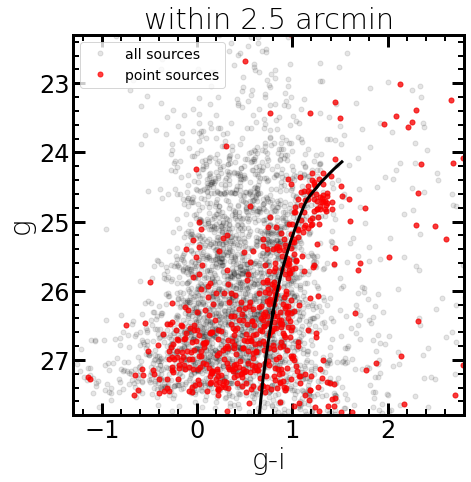

In [58]:
plt.rcParams.update({'figure.figsize' : (7, 7)})

plt.figure()

okstage = (iso['stage'] <= 3)

plt.plot(mags_g['psfmag'][is_primary & deblended & sel_cen][:,0]-mags_i['psfmag'][is_primary & deblended & sel_cen][:,0],\
         mags_g['psfmag'][is_primary & deblended & sel_cen][:,0], 'ko', ms=5, alpha=0.1, label='all sources')
plt.plot(mags_g['psfmag'][is_primary & deblended & starsel_i & sel_cen][:,0]-mags_i['psfmag'][is_primary & deblended & starsel_i & sel_cen][:,0],\
         mags_g['psfmag'][is_primary & deblended & starsel_i & sel_cen][:,0], 'ro', ms=5, alpha=0.75, label='point sources')
plt.plot(g_iso[okstage]-i_iso[okstage], g_iso[okstage], 'k', label='__no label__')#s', ms=1)
plt.xlabel('g-i')
plt.ylabel('g')
plt.legend()
plt.xlim(-1.3,2.8)
plt.ylim(27.8,22.3)
plt.title('within 2.5 arcmin')
plt.minorticks_on()

plt.show()

## Summary

In this notebook, we explored the photometry around a dwarf galaxy in the HSC dataset, with a particular interest in extracting scientifically useful photometry for stars in this nearby, partially-resolved galaxy.

Among other things, we did the following: 

* Identified the tract and patch containing an object of known coordinates.

* Extracted cutout images and catalogs centered on the identified position, including data from multiple patches if needed. There is a beautiful dwarf galaxy -- KKR 25 -- in the images, which we explored in more detail.

* Plotted a color-magnitude diagram centered on the object of interest. In this particular case, the red giant branch of dwarf galaxy KKR 25 is not evident in the CMD, even though it looks like it _should_ be.

* Used a variety of measured quantities from the source catalogs to (a) determine that the stars in KKR 25 are being detected, but just have poor measurements, and (b) to explore why their measurements are all consistent with having zero flux.

* Following the Stack Club "Footprints" notebook in the Source Detection section: https://stackclub.readthedocs.io/en/latest/notebooks.html#source-detection, we looked at source footprints within the KKR 25 region and determined that the issue is that some footprints are _huge_, and that the default behavior of the measurement algorithm(s) to replace neighboring footprints with noise was causing all of the sources to get replaced with noise, too. 

* Reprocessed a small chunk of data with the flag `doReplaceWithNoise` set to `False`. This allows sources to be measured even in the crowded regions of KKR 25.

* We checked the CMD of this newly-processed dataset, and found that the red giant branch of KKR 25 is clearly visible, and the photometry looks good! From here, we could proceed with our scientific exploration.